In [1]:
import datetime as dt

from matplotlib.patches import Rectangle
import numpy as np
import pandas as pd
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

# 1. Import the sqlalchemy extract function.
from sqlalchemy import extract

## Connect to the Database

In [2]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [3]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [4]:
# Inspect to see the column names for each reflected table
ins_meas = inspect(Measurement)
meas_col = [col.key for col in ins_meas.mapper.column_attrs]
ins_station = inspect(Station)
station_col = [col.key for col in ins_station.mapper.column_attrs]

# Print the columns
print('measurement columns =', meas_col)
print('station columns =', station_col)

measurement columns = ['id', 'station', 'date', 'prcp', 'tobs']
station columns = ['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


## Deliverable 1: Determine the Summary Statistics for Temperatures in June

In [5]:
# 2. Write a query that filters the Measurement table to retrieve the 
# temperatures for the month of June. 
jun_temps = (session.query(Measurement.tobs)
                     .filter(extract('month', Measurement.date) == 6)
                     .all())

In [6]:
#  3. Convert the June temperatures to a list.
jun_temps = list(np.ravel(jun_temps))

In [7]:
# 4. Create a DataFrame from the list of temperatures for the month of June.
jun_temps_df = pd.DataFrame(jun_temps, columns=['June Temps'])

In [8]:
# 5. Calculate and print out the summary statistics for the June temperature
# DataFrame.
jun_temps_df.describe()

,June Temps
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


## Deliverable 2: Determine the Summary Statistics for Temperatures in December

In [9]:
# 6. Write a query that filters the Measurement table to retrieve the
# temperatures for the month of December.
dec_temps = (session.query(Measurement.tobs)
                         .filter(extract('month', Measurement.date) == 12)
                         .all())

In [10]:
# 7. Convert the December temperatures to a list.
dec_temps = list(np.ravel(dec_temps))

In [11]:
# 8. Create a DataFrame from the list of temperatures for the month of December. 
dec_temps_df = pd.DataFrame(dec_temps, columns=['December Temps'])

In [12]:
# 9. Calculate and print out the summary statistics for the December
# temperature DataFrame.
dec_temps_df.describe()

,December Temps
count,1517.000000
mean,71.041529
std,3.745920
min,56.000000
25%,69.000000
50%,71.000000
75%,74.000000
max,83.000000


## Additional Queries

### Additional Query 1: Average Daily Temperture for June and December

In [13]:
# First create two subqueries containing the temperature and precipitation data 
# for each month grouped by the day of the month.
# June average daily temperatures and precipitations
jun_subq = (session.query(extract('day', Measurement.date).label('day'),
                          (func.sum(Measurement.tobs)/func.count(Measurement.tobs)).label('j_temp'),
                          (func.sum(Measurement.prcp)/func.count(Measurement.prcp)).label('j_prcp'))
                   .filter(extract('month', Measurement.date) == 6)
                   .group_by(extract('day', Measurement.date))
                   .subquery('jun'))
# December average daily temperatures and precipitations
dec_subq = (session.query(extract('day', Measurement.date).label('day'),
                          (func.sum(Measurement.tobs)/func.count(Measurement.tobs)).label('d_temp'),
                          (func.sum(Measurement.prcp)/func.count(Measurement.prcp)).label('d_prcp'))
                   .filter(extract('month', Measurement.date) == 12)
                   .group_by(extract('day', Measurement.date))
                   .subquery('dec'))

# Join the two subqueries on the day column
daily_averages = (session.query(dec_subq.c.day,
                                jun_subq.c.j_temp,
                                dec_subq.c.d_temp,
                                jun_subq.c.j_prcp,
                                dec_subq.c.d_prcp)
                          .outerjoin(jun_subq, dec_subq.c.day == jun_subq.c.day)
                          .all())

# Create a DataFrame from the daily_averages query
daily_averages_df = pd.DataFrame(daily_averages, columns=['day',
                                                          'jun_temp',
                                                          'dec_temp',
                                                          'jun_prcp',
                                                          'dec_prcp'])

# Use the day of the month as the index
daily_averages_df.set_index(['day'], inplace=True)

#### Average Daily Temperature Plot

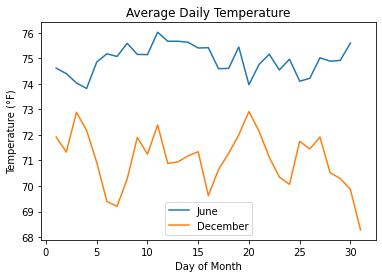

In [14]:
# Average Daily Temperature (ADT) plot
ax = daily_averages_df[['jun_temp','dec_temp']].plot(title='Average Daily Temperature',
                                                     xlabel='Day of Month',
                                                     ylabel='Temperature (°F)')
ax.legend(labels=['June', 'December'])
fig = ax.get_figure()
fig.patch.set_facecolor('white')
# fig.add_artist(Rectangle((0, 0), width=1, height=1, facecolor='none', edgecolor='black'))
fig.savefig('Resources/avg_daily_temperature.svg')

#### Average Daily Precipitation Plot

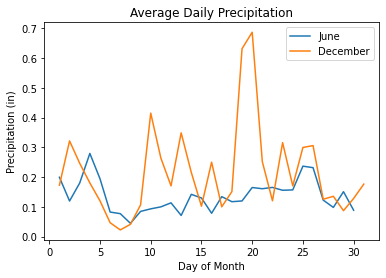

In [15]:
# Average Daily Precipitation (ADT) plot
ax = daily_averages_df[['jun_prcp','dec_prcp']].plot(title='Average Daily Precipitation',
                                                     xlabel='Day of Month',
                                                     ylabel='Precipitation (in)')
ax.legend(labels=['June', 'December'])
fig = ax.get_figure()
fig.patch.set_facecolor('white')
# fig.add_artist(Rectangle((0, 0), width=1, height=1, facecolor='none', edgecolor='black'))
fig.savefig('Resources/avg_daily_precipitation.svg')

### Additional Query 2: Determine the Summary Statistics for Precipitation in June

In [16]:
# Filter the Measurement table to retrieve the precipitation for the month of 
# June. 
jun_prcp = (session.query(Measurement.prcp)
                    .filter(extract('month', Measurement.date) == 6)
                    .all())

# Convert the June precipitations to a list.
jun_prcp = list(np.ravel(jun_prcp))

# Create a DataFrame from the list of precipitations for the month of June.
jun_prcp_df = pd.DataFrame(jun_prcp, columns=['June Precipitation'])

# Calculate and print out the summary statistics for the June precipitation
# DataFrame.
jun_prcp_stats_df = jun_prcp_df.describe()
jun_prcp_stats_df

,June Precipitation
count,1574.000000
mean,0.136360
std,0.335731
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.430000


### Additional Query 3: Determine the Summary Statistics for Precipitation in December

In [17]:
# Filter the Measurement table to retrieve the precipitation for the month of 
# December. 
dec_prcp = (session.query(Measurement.prcp)
                        .filter(extract('month', Measurement.date) == 12)
                        .all())

# Convert the December precipitations to a list.
dec_prcp = list(np.ravel(dec_prcp))

# Create a DataFrame from the list of precipitations for the month of December.
dec_prcp_df = pd.DataFrame(dec_prcp, columns=['December Precipitation'])

# Calculate and print out the summary statistics for the December precipitation
# DataFrame.
dec_prcp_stats_df = dec_prcp_df.describe()
dec_prcp_stats_df

,December Precipitation
count,1405.000000
mean,0.216819
std,0.541399
min,0.000000
25%,0.000000
50%,0.030000
75%,0.150000
max,6.420000


### Combine Table AQ2 and AQ3 for Reporting

In [18]:
# Use the indexes of each DataFrame as the keys for merging
prcp_stats_df = jun_prcp_stats_df.merge(dec_prcp_stats_df, left_index=True, right_index=True)
prcp_stats_df

,June Precipitation,December Precipitation
count,1574.000000,1405.000000
mean,0.136360,0.216819
std,0.335731,0.541399
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.020000,0.030000
75%,0.120000,0.150000
max,4.430000,6.420000


### Additional Query 4: Min/Max Temperature for June and December

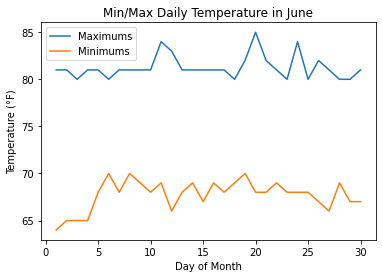

In [19]:
# June min/max (mm) temperatures for all years
jun_mm_temp = (session.query(extract('day', Measurement.date),
                             func.max(Measurement.tobs),
                             func.min(Measurement.tobs))
                      .filter(extract('month', Measurement.date) == 6)
                      .group_by(extract('day', Measurement.date))
                      .all())

# Create a DataFrame
jun_mm_temp_df = pd.DataFrame(jun_mm_temp, columns=['day',
                                                    'jun_max_temp',
                                                    'jun_min_temp'])

# Set the index to the day of the month
jun_mm_temp_df.set_index(['day'], inplace=True)

# Plot the min/max values
ax = jun_mm_temp_df.plot(title='Min/Max Daily Temperature in June',
                         xlabel='Day of Month',
                         ylabel='Temperature (°F)')
ax.legend(labels=['Maximums', 'Minimums'])
fig = ax.get_figure()
fig.patch.set_facecolor('white')
# fig.add_artist(Rectangle((0, 0), width=1, height=1, facecolor='none', edgecolor='black'))
fig.savefig('Resources/min_max_daily_temperature_june.svg')

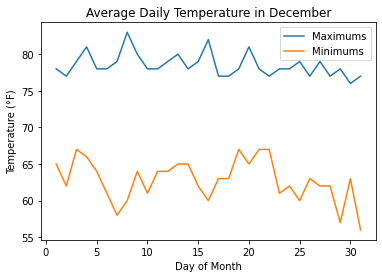

In [20]:
# December min/max (mm) temperatures for all years
dec_mm_temp = (session.query(extract('day', Measurement.date),
                             func.max(Measurement.tobs),
                             func.min(Measurement.tobs))
                      .filter(extract('month', Measurement.date) == 12)
                      .group_by(extract('day', Measurement.date))
                      .all())

# Create a DataFrame
dec_mm_temp_df = pd.DataFrame(dec_mm_temp, columns=['day',
                                                    'dec_max_temp',
                                                    'dec_min_temp'])

# Set the index to the day of the month
dec_mm_temp_df.set_index(['day'], inplace=True)

# Plot the min/max values
ax = dec_mm_temp_df.plot(title='Average Daily Temperature in December',
                         xlabel='Day of Month',
                         ylabel='Temperature (°F)')
ax.legend(labels=['Maximums', 'Minimums'])
fig = ax.get_figure()
fig.patch.set_facecolor('white')
# fig.add_artist(Rectangle((0, 0), width=1, height=1, facecolor='none', edgecolor='black'))
fig.savefig('Resources/min_max_daily_temperature_december.svg')